# Awkward *Quick, Draw!* GAN with No Warning

In this notebook, we use an awkward workaround to avoid the unnecessary Keras warning produced by our [*Quick, Draw!* GAN](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/generative_adversarial_network.ipynb).

_In order to efficiently carry out the training in this notebook, we recommend using a GPU. Most readers don't have a GPU suitable for TensorFlow operations (i.e., an Nvidia GPU with CUDA and cuDNN drivers installed) available on their local machine, however you can easily access one for free via [Colab](https://colab.research.google.com/)._ 

_Separately, for reasons that escape us, the discriminator in this notebook nearly always fails to learn if you train on a CPU only. Because of this failure, the GAN will seldom learn how to generate sketches -- i.e., it will output images that are merely random noise. There are two ways we've identified to remedy this situation:_ 

1. _**Use a GPU.** If you don't have one, use Colab as suggested above. While in Colab, you can select "Change runtime type" from the "Runtime" item in the menu bar, and choose "GPU" as your hardware accelerator. This hardware accelerator trains the GAN orders of magnitude more rapidly than the "None" or "TPU" options, and the discriminator (we have no idea why!) will train properly._
2. _**Change the discriminator's optimizer.** As noted by a comment in this notebook's discriminator compilation step, switching from the default RMSprop optimizer to another (e.g., Adam or AdaDelta) enables the discriminator to learn effectively and therefore the GAN generates sketches. Whether you use a CPU only, a GPU, or a TPU, this solution is effective. (That said, training the GAN with a GPU is still way faster than with a CPU only or a TPU.)_

#### Load dependencies

In [1]:
%pip install -r /workspace/requirements_cpu.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 10.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 76.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.5/770.5 kB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127283 sha256=e84fe5c28d5f57e8e6dc894633965d779870926b5b0bffecb9f1564e3a2abf23
  Stored in di

In [15]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
#import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new! 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D # new! 
from tensorflow.keras.optimizers.legacy import RMSprop # new!
from tensorflow.keras import backend as K

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Load data
NumPy bitmap files are [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- pick your own drawing category -- you don't have to pick *apples* :)

In [3]:
input_images = "/workspace/quickdraw_data/apple.npy"

In [4]:
data = np.load(input_images) # 28x28 (sound familiar?) grayscale bitmap in numpy .npy format; images are centered

In [5]:
data.shape

(144722, 784)

In [ ]:
# data[4242]

In [6]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
# data.shape

In [7]:
# data[4242]

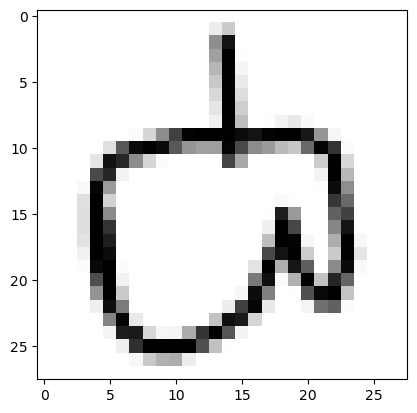

In [8]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Create discriminator network

In [16]:
def build_discriminator(depth=64, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid', name='prediction')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [17]:
discriminator = build_discriminator()

In [18]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 256)         0   

In [19]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(learning_rate=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['binary_accuracy'])

#### Build an untrainable discriminator

To create a workaround that avoids the following (unnecessary!) warning being thrown by recent versions of Keras...

`Discrepancy between trainable weights and collected trainable weights, did you set model.trainable without calling model.compile after ?`

...we awkwardly build a second, discriminator (`discriminator_`) for use in the adversarial model. This model is identical to the first discriminator (`discriminator`) except that it's unequivocally _untrainable_ (it isn't even compiled!). We copy the weights from the trainable `discriminator` model into the untrainable `discriminator_` model each time we want to use it. Thus, the adversarial model gets a fresh _copy_ of the discriminator's parameters in each round of training.

In [20]:
# Build an identical discriminator: 
discriminator_ = build_discriminator()

# Set the model so that its parameters are frozen: 
discriminator_.trainable = False

In [21]:
# Function to copy the weights from the trainable discriminator to the frozen discriminator_
def copy_weights(source, target):
    for i, layer in enumerate(source.layers):
        target.layers[i].set_weights(source.layers[i].get_weights())

#### Create generator network

In [22]:
z_dimensions = 32

In [23]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [24]:
generator = build_generator()

In [ ]:
# generator.compile(loss='binary_crossentropy', 
#                           optimizer=RMSprop(lr=0.0004, 
#                                             decay=3e-8, 
#                                             clipvalue=1.0), 
#                           metrics=['accuracy'])

In [ ]:
# generator.summary()

#### Create adversarial network

In [25]:
def build_adversarial():
          
    # Define input
    z = Input(shape=(z_dimensions,))
    
    # Generate image from noise
    img = generator(z)
    
    # Make prediction
    pred = discriminator_(img)
       
    # Build model
    model = Model(inputs=z, outputs=pred)
    
    return model

In [26]:
adversarial_model = build_adversarial()

In [ ]:
# adversarial_model.summary()

In [27]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(learning_rate=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Train!

In [31]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        #######################
        # train discriminator:#
        #######################
        
        # sample real images: 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator:
        # Added noisy labels, as per here: https://link.medium.com/yUuw4Y33PX
        # Note: disciminator accuracy will always be zero now...
        y = np.ones([2*batch,1]) - np.random.uniform(0,0.1,[2*batch,1])
        y[batch:,:] = 0
        y[batch:,:] += np.random.uniform(0,0.1,[batch,1])
        
        # do training
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        #########################
        # train adversarial net:#
        #########################
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # Copy weights to frozen discriminator
        copy_weights(discriminator, discriminator_)
        
        # do training
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        #########################
        #     Print results     #
        #########################
        
        # periodically print progress & fake images: 
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

4/4 [==============================] - 0s 12ms/step
Epoch #19
19: [D loss: 0.674505, acc: 0.000000]  [A loss: 0.697889, acc: 0.733964]
1/1 [==============================] - 0s 87ms/step


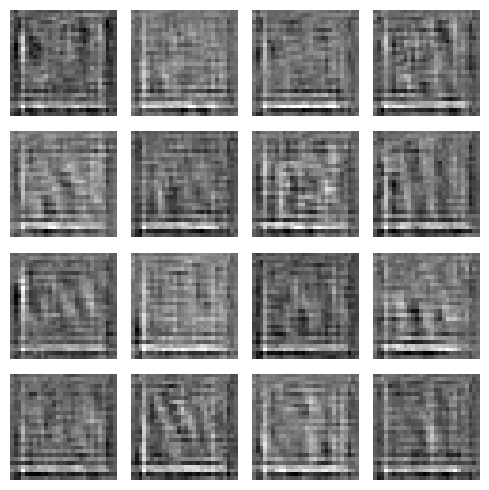

4/4 [==============================] - 0s 12ms/step
Epoch #39
39: [D loss: 0.451338, acc: 0.000000]  [A loss: 0.680264, acc: 0.725160]
1/1 [==============================] - 0s 16ms/step


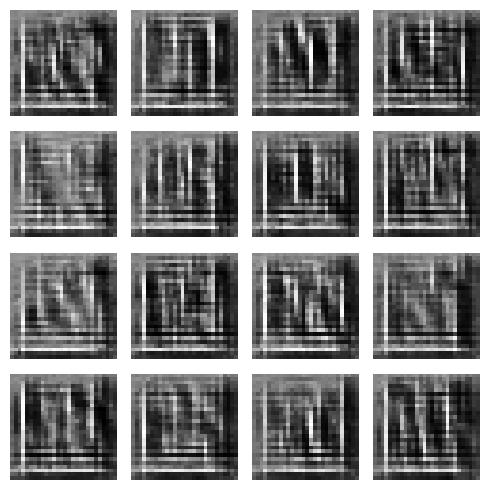

4/4 [==============================] - 0s 12ms/step
Epoch #59
59: [D loss: 0.391128, acc: 0.000000]  [A loss: 1.084867, acc: 0.522113]
1/1 [==============================] - 0s 16ms/step


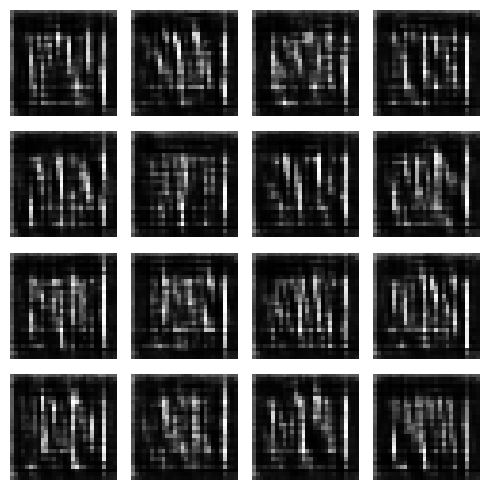

4/4 [==============================] - 0s 16ms/step
Epoch #79
79: [D loss: 0.377845, acc: 0.000000]  [A loss: 1.456573, acc: 0.407239]
1/1 [==============================] - 0s 15ms/step


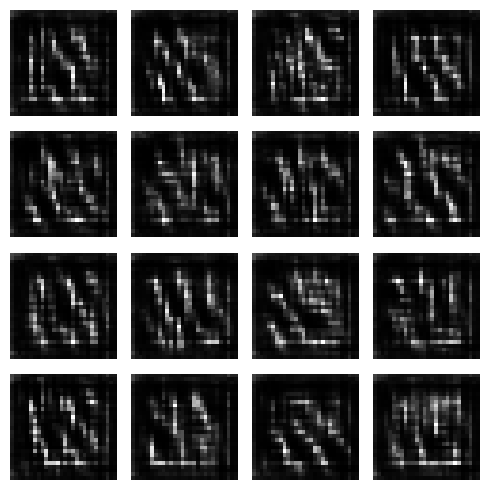

4/4 [==============================] - 0s 12ms/step
Epoch #99
99: [D loss: 0.348188, acc: 0.000000]  [A loss: 1.805018, acc: 0.325205]
1/1 [==============================] - 0s 23ms/step


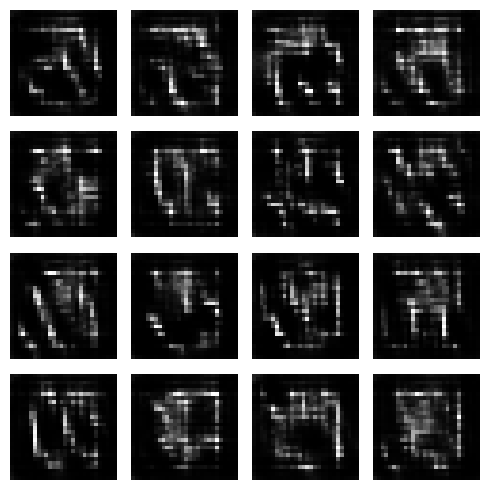

4/4 [==============================] - 0s 12ms/step
Epoch #119
119: [D loss: 0.337649, acc: 0.000000]  [A loss: 2.016139, acc: 0.279084]
1/1 [==============================] - 0s 16ms/step


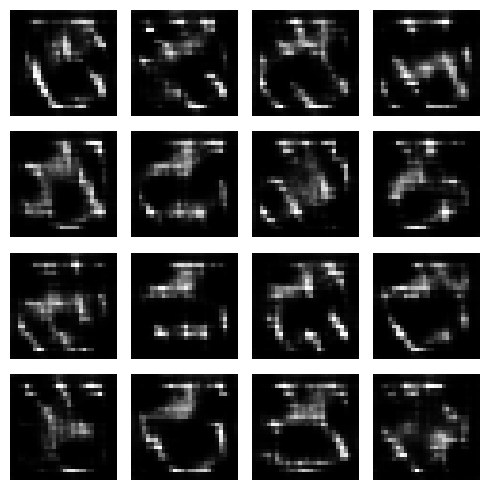

4/4 [==============================] - 0s 12ms/step
Epoch #139
139: [D loss: 0.340249, acc: 0.000000]  [A loss: 2.106699, acc: 0.251180]
1/1 [==============================] - 0s 15ms/step


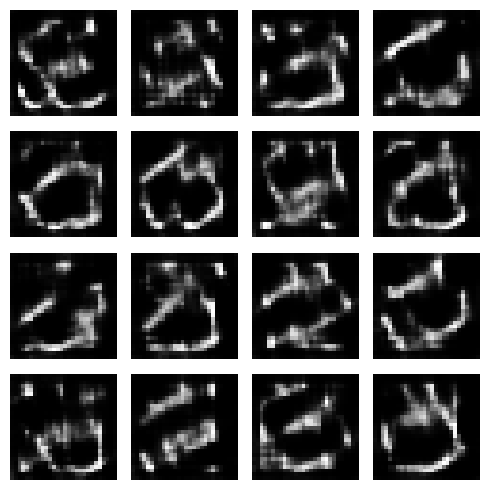

4/4 [==============================] - 0s 12ms/step
Epoch #159
159: [D loss: 0.344310, acc: 0.000000]  [A loss: 2.173967, acc: 0.230739]
1/1 [==============================] - 0s 17ms/step


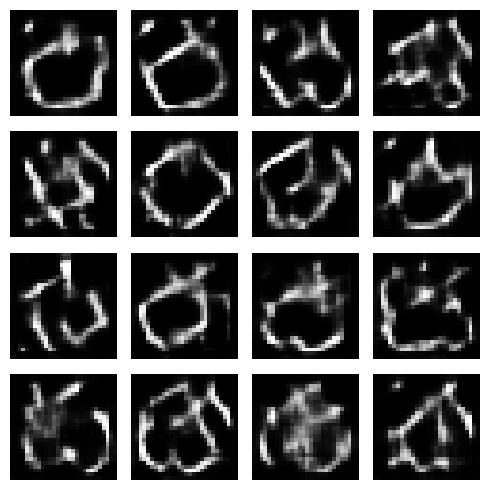

4/4 [==============================] - 0s 13ms/step
Epoch #179
179: [D loss: 0.347520, acc: 0.000000]  [A loss: 2.212986, acc: 0.215477]
1/1 [==============================] - 0s 16ms/step


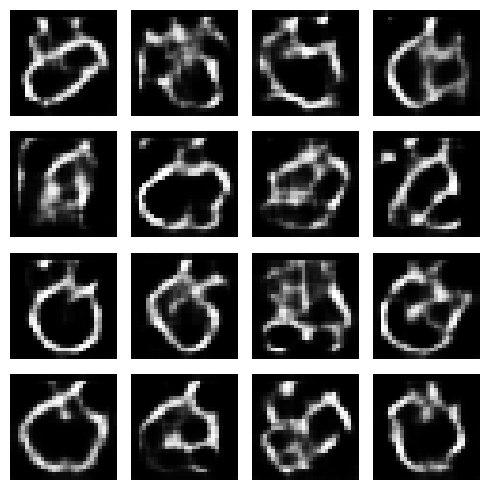

4/4 [==============================] - 0s 13ms/step
Epoch #199
199: [D loss: 0.359196, acc: 0.000000]  [A loss: 2.193026, acc: 0.205912]
1/1 [==============================] - 0s 16ms/step


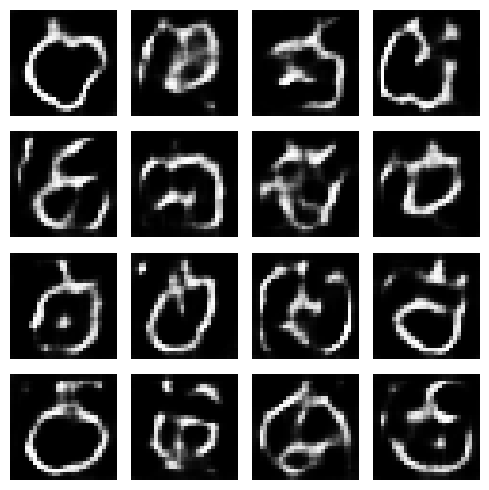

4/4 [==============================] - 0s 13ms/step
Epoch #219
219: [D loss: 0.367948, acc: 0.000000]  [A loss: 2.173585, acc: 0.197738]
1/1 [==============================] - 0s 17ms/step


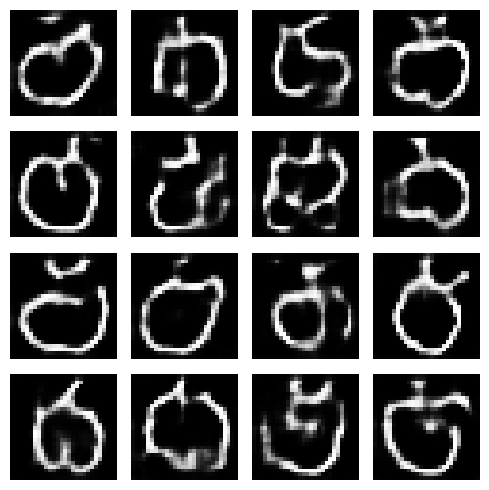

4/4 [==============================] - 0s 12ms/step
Epoch #239
239: [D loss: 0.376129, acc: 0.000000]  [A loss: 2.141774, acc: 0.196064]
1/1 [==============================] - 0s 16ms/step


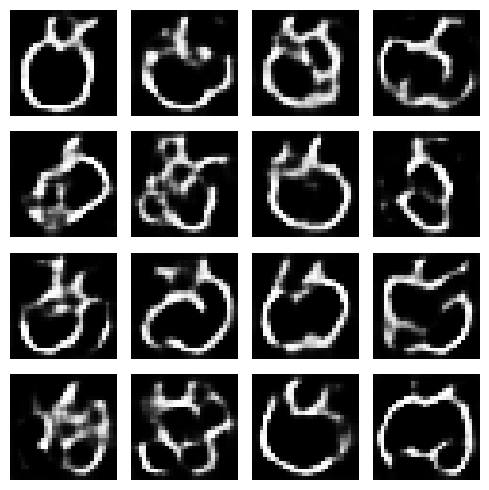

4/4 [==============================] - 0s 12ms/step
Epoch #259
259: [D loss: 0.382673, acc: 0.000000]  [A loss: 2.109179, acc: 0.193985]
1/1 [==============================] - 0s 17ms/step


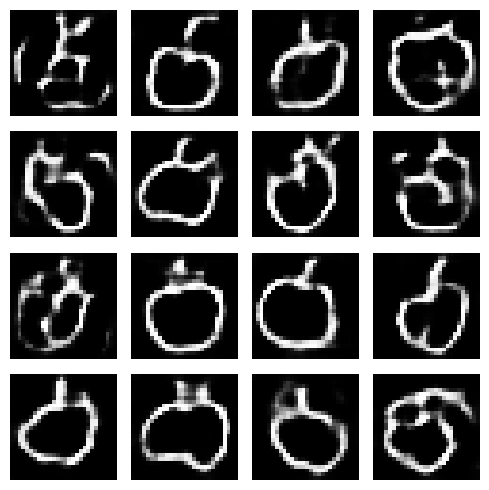

4/4 [==============================] - 0s 12ms/step
Epoch #279
279: [D loss: 0.390585, acc: 0.000000]  [A loss: 2.070609, acc: 0.196349]
1/1 [==============================] - 0s 16ms/step


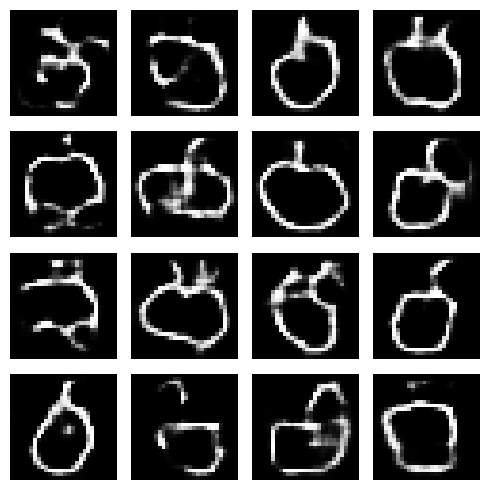

4/4 [==============================] - 0s 16ms/step
Epoch #299
299: [D loss: 0.397487, acc: 0.000000]  [A loss: 2.031714, acc: 0.195312]
1/1 [==============================] - 0s 16ms/step


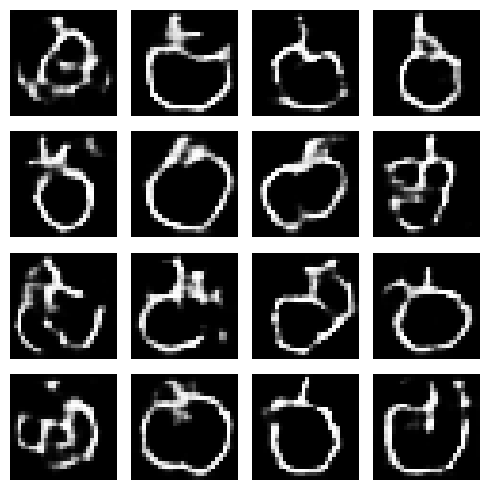

4/4 [==============================] - 0s 12ms/step
Epoch #319
319: [D loss: 0.403335, acc: 0.000000]  [A loss: 2.007171, acc: 0.191590]
1/1 [==============================] - 0s 16ms/step


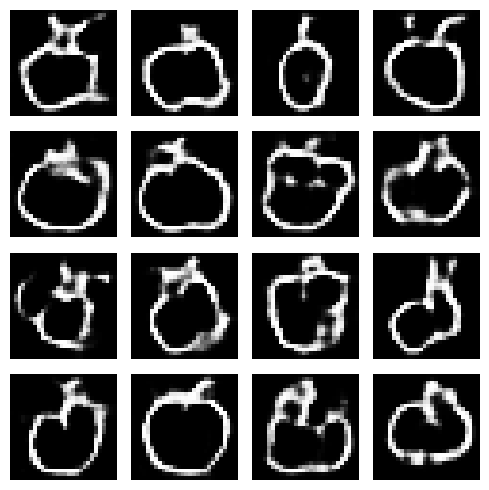

4/4 [==============================] - 0s 12ms/step
Epoch #339
339: [D loss: 0.408912, acc: 0.000000]  [A loss: 1.978388, acc: 0.189989]
1/1 [==============================] - 0s 17ms/step


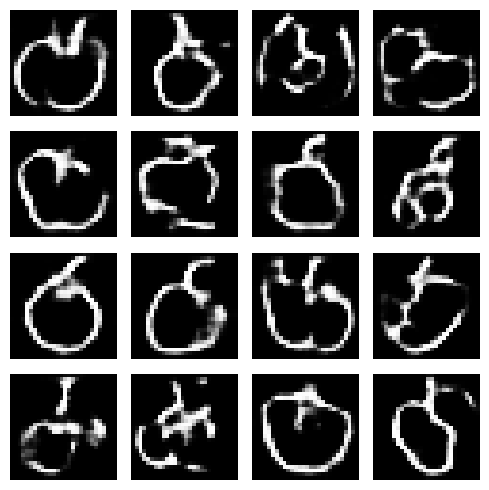

4/4 [==============================] - 0s 13ms/step
Epoch #359
359: [D loss: 0.413652, acc: 0.000000]  [A loss: 1.956241, acc: 0.187065]
1/1 [==============================] - 0s 17ms/step


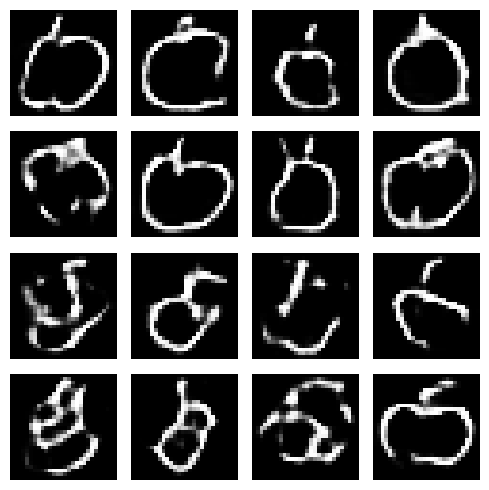

4/4 [==============================] - 0s 12ms/step
Epoch #379
379: [D loss: 0.417925, acc: 0.000000]  [A loss: 1.941093, acc: 0.184367]
1/1 [==============================] - 0s 16ms/step


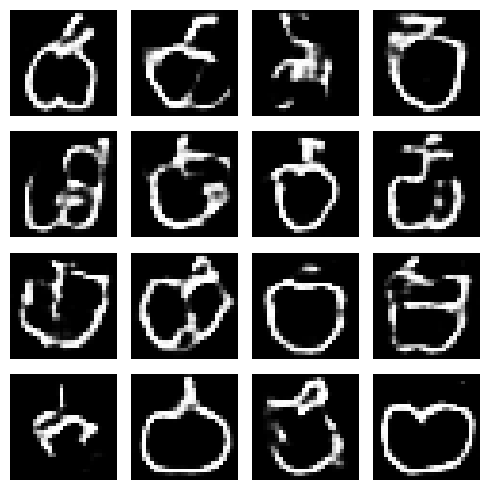

4/4 [==============================] - 0s 12ms/step
Epoch #399
399: [D loss: 0.421482, acc: 0.000000]  [A loss: 1.924836, acc: 0.182468]
1/1 [==============================] - 0s 16ms/step


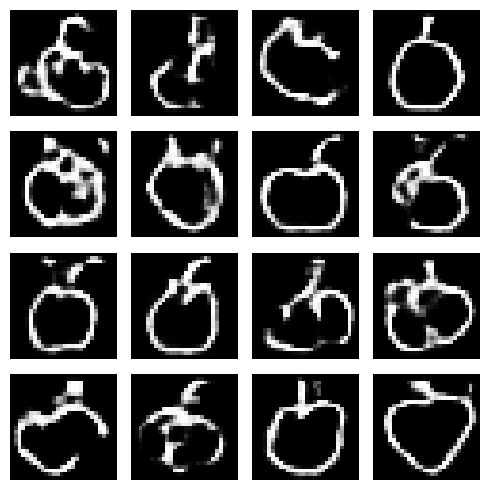

4/4 [==============================] - 0s 12ms/step
Epoch #419
419: [D loss: 0.425688, acc: 0.000000]  [A loss: 1.907336, acc: 0.180545]
1/1 [==============================] - 0s 16ms/step


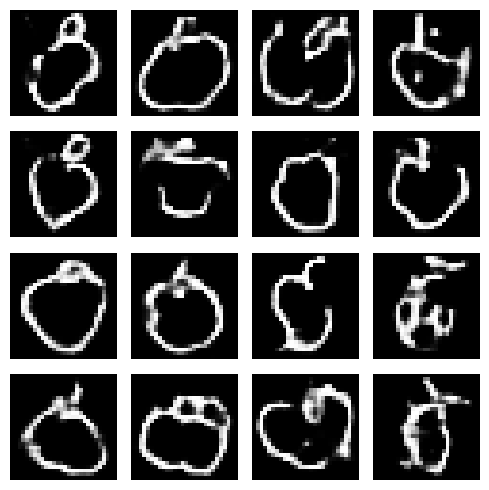

4/4 [==============================] - 0s 12ms/step
Epoch #439
439: [D loss: 0.428597, acc: 0.000000]  [A loss: 1.894044, acc: 0.177908]
1/1 [==============================] - 0s 17ms/step


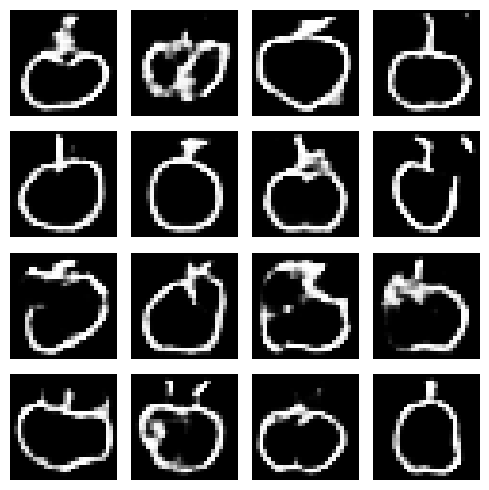

4/4 [==============================] - 0s 12ms/step
Epoch #459
459: [D loss: 0.432182, acc: 0.000000]  [A loss: 1.881504, acc: 0.176317]
1/1 [==============================] - 0s 16ms/step


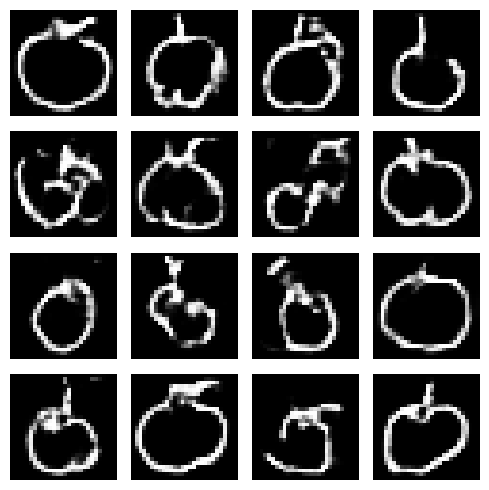

4/4 [==============================] - 0s 13ms/step
Epoch #479
479: [D loss: 0.435112, acc: 0.000000]  [A loss: 1.868379, acc: 0.175251]
1/1 [==============================] - 0s 17ms/step


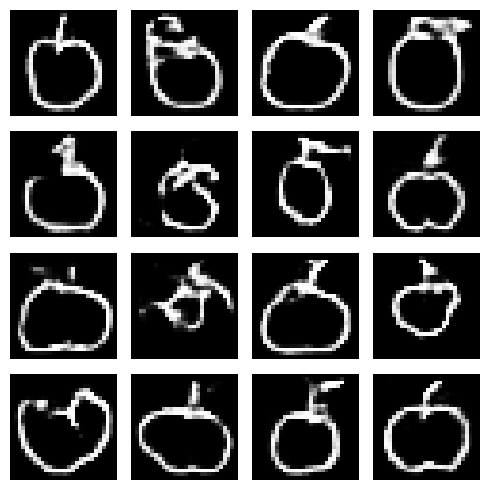

4/4 [==============================] - 0s 12ms/step
Epoch #499
499: [D loss: 0.438409, acc: 0.000000]  [A loss: 1.855272, acc: 0.173848]
1/1 [==============================] - 0s 16ms/step


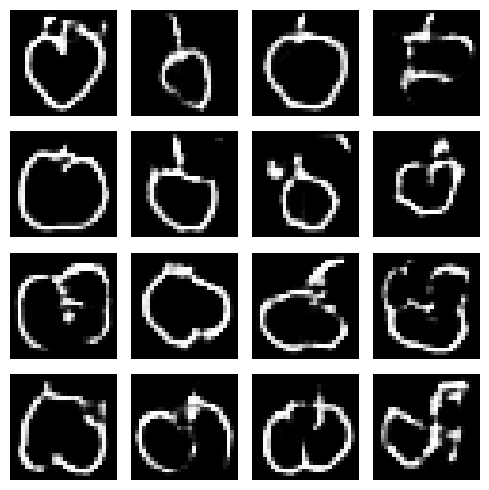

4/4 [==============================] - 0s 12ms/step
Epoch #519
519: [D loss: 0.441064, acc: 0.000000]  [A loss: 1.844860, acc: 0.172146]
1/1 [==============================] - 0s 16ms/step


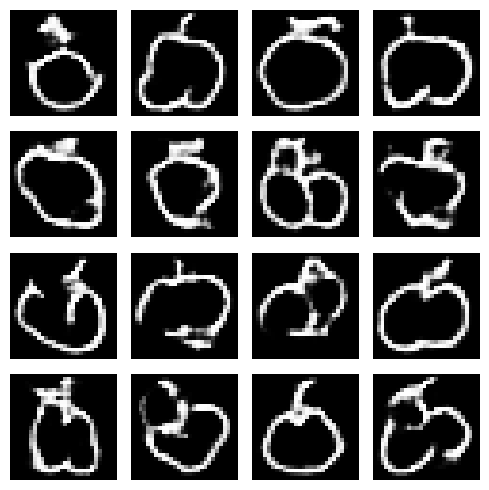

4/4 [==============================] - 0s 12ms/step
Epoch #539
539: [D loss: 0.443148, acc: 0.000000]  [A loss: 1.836293, acc: 0.171165]
1/1 [==============================] - 0s 16ms/step


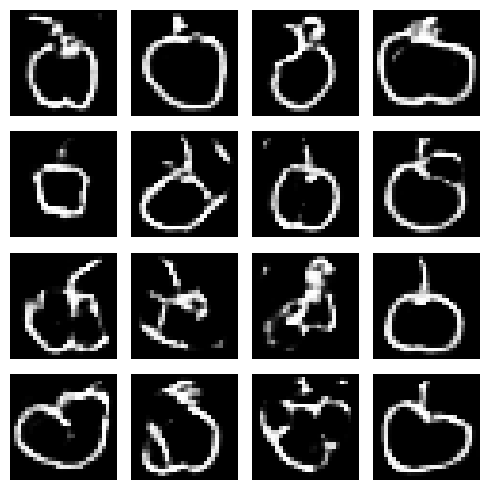

4/4 [==============================] - 0s 12ms/step
Epoch #559
559: [D loss: 0.445238, acc: 0.000000]  [A loss: 1.829295, acc: 0.169932]
1/1 [==============================] - 0s 17ms/step


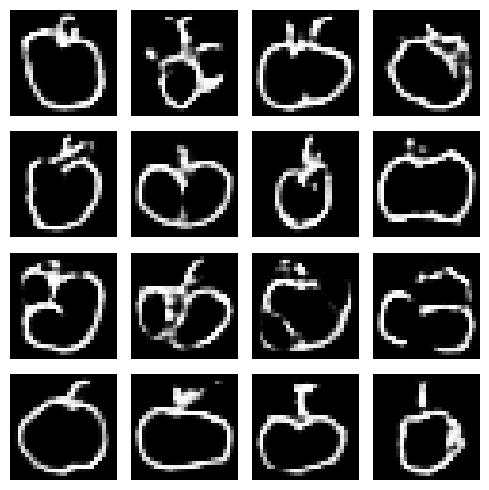

4/4 [==============================] - 0s 12ms/step
Epoch #579
579: [D loss: 0.447225, acc: 0.000000]  [A loss: 1.820190, acc: 0.170094]
1/1 [==============================] - 0s 17ms/step


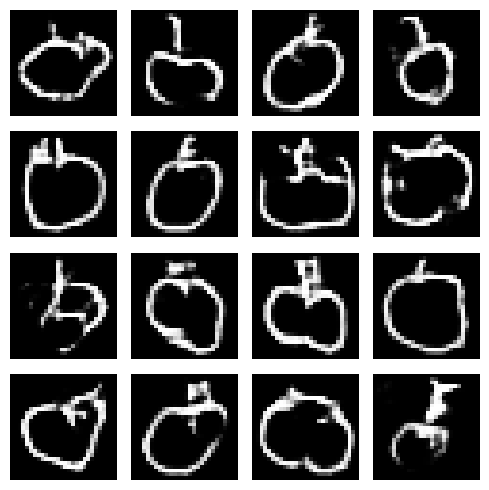

4/4 [==============================] - 0s 12ms/step
Epoch #599
599: [D loss: 0.448411, acc: 0.000000]  [A loss: 1.815383, acc: 0.169332]
1/1 [==============================] - 0s 16ms/step


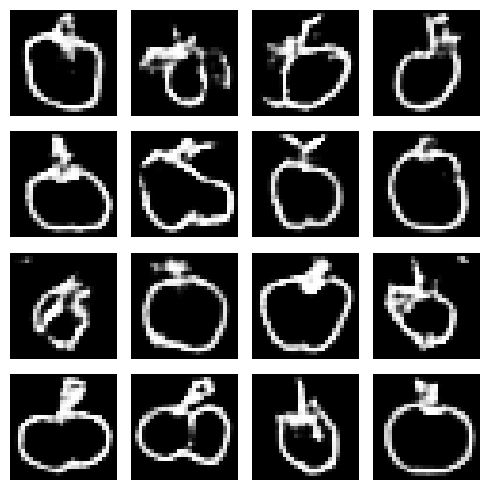

4/4 [==============================] - 0s 12ms/step
Epoch #619
619: [D loss: 0.449661, acc: 0.000000]  [A loss: 1.810918, acc: 0.168581]
1/1 [==============================] - 0s 16ms/step


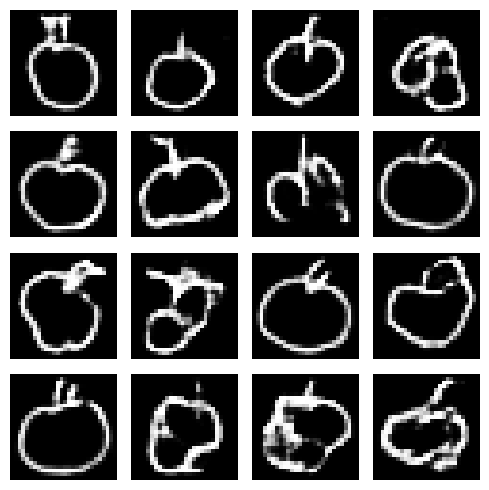

4/4 [==============================] - 0s 13ms/step
Epoch #639
639: [D loss: 0.451065, acc: 0.000000]  [A loss: 1.805273, acc: 0.167987]
1/1 [==============================] - 0s 16ms/step


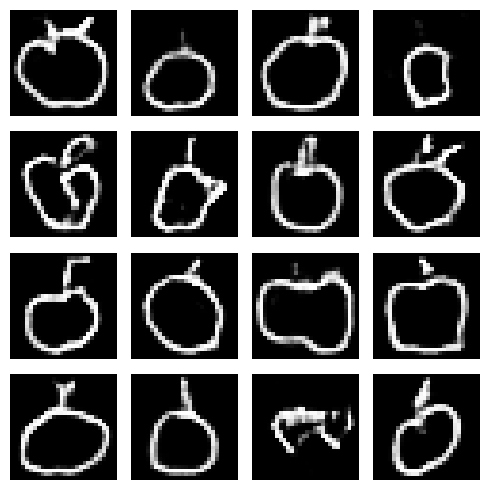

4/4 [==============================] - 0s 12ms/step
Epoch #659
659: [D loss: 0.452332, acc: 0.000000]  [A loss: 1.800529, acc: 0.167275]
1/1 [==============================] - 0s 16ms/step


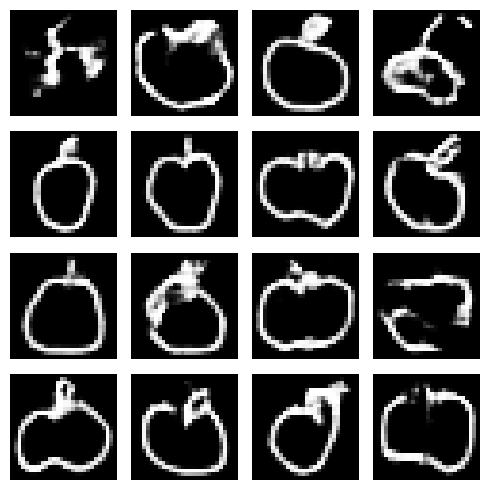

4/4 [==============================] - 0s 12ms/step
Epoch #679
679: [D loss: 0.453670, acc: 0.000000]  [A loss: 1.793954, acc: 0.166927]
1/1 [==============================] - 0s 17ms/step


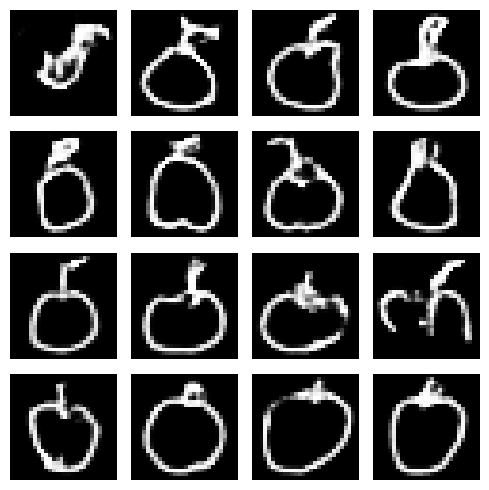

4/4 [==============================] - 0s 13ms/step
Epoch #699
699: [D loss: 0.454438, acc: 0.000000]  [A loss: 1.791812, acc: 0.166074]
1/1 [==============================] - 0s 16ms/step


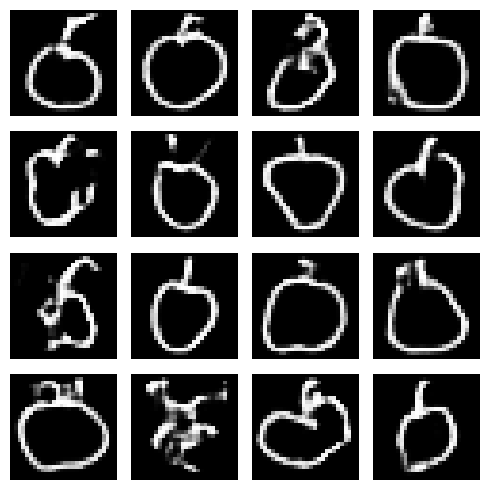

4/4 [==============================] - 0s 12ms/step
Epoch #719
719: [D loss: 0.455431, acc: 0.000000]  [A loss: 1.787737, acc: 0.165442]
1/1 [==============================] - 0s 16ms/step


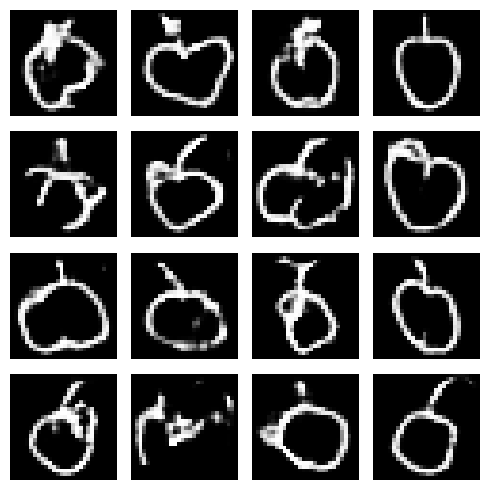

4/4 [==============================] - 0s 12ms/step
Epoch #739
739: [D loss: 0.456664, acc: 0.000000]  [A loss: 1.785258, acc: 0.164538]
1/1 [==============================] - 0s 17ms/step


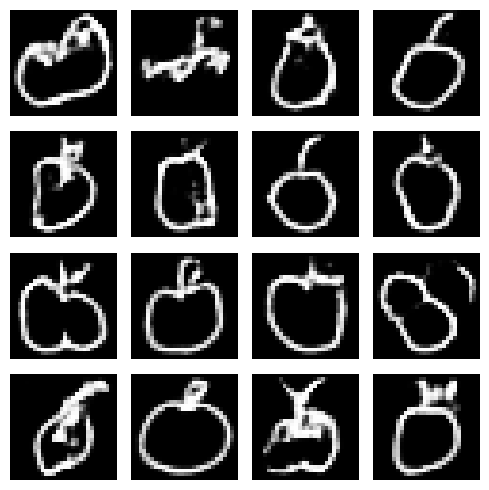

4/4 [==============================] - 0s 12ms/step
Epoch #759
759: [D loss: 0.457473, acc: 0.000000]  [A loss: 1.781569, acc: 0.163702]
1/1 [==============================] - 0s 16ms/step


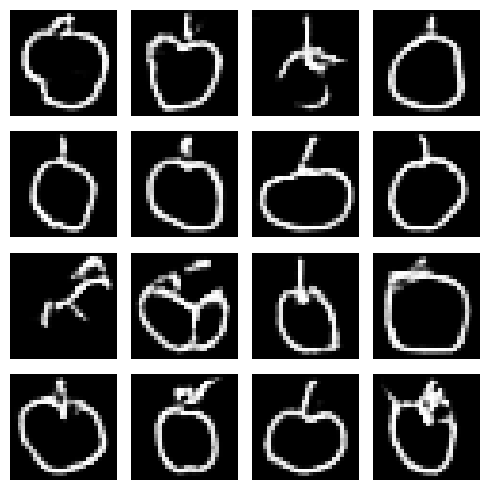

4/4 [==============================] - 0s 13ms/step
Epoch #779
779: [D loss: 0.458033, acc: 0.000000]  [A loss: 1.780367, acc: 0.163350]
1/1 [==============================] - 0s 16ms/step


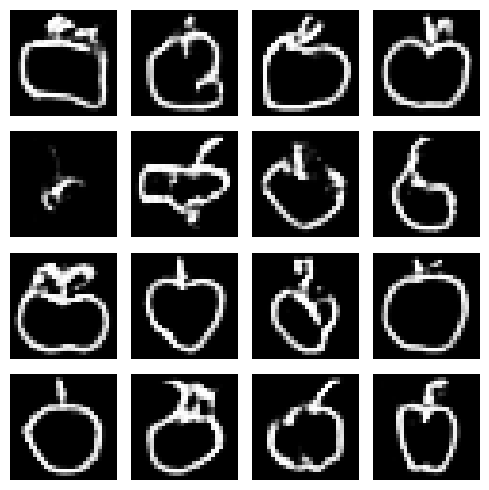

4/4 [==============================] - 0s 12ms/step
Epoch #799
799: [D loss: 0.458778, acc: 0.000000]  [A loss: 1.776130, acc: 0.162723]
1/1 [==============================] - 0s 16ms/step


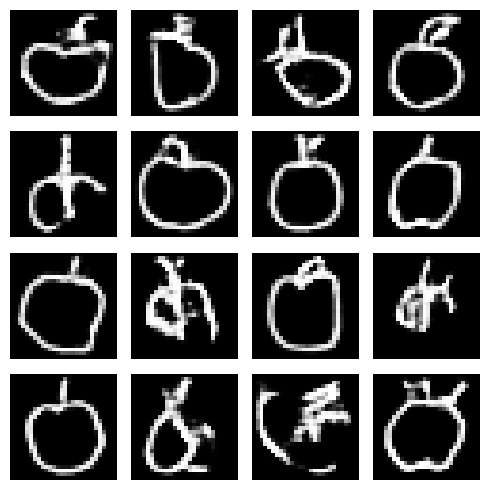

4/4 [==============================] - 0s 12ms/step
Epoch #819
819: [D loss: 0.459044, acc: 0.000000]  [A loss: 1.775339, acc: 0.162260]
1/1 [==============================] - 0s 16ms/step


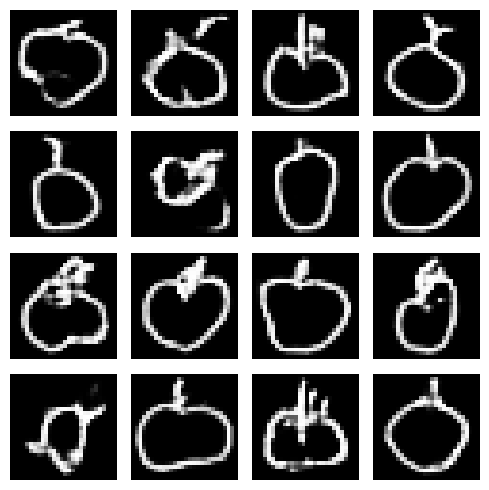

4/4 [==============================] - 0s 12ms/step
Epoch #839
839: [D loss: 0.459572, acc: 0.000000]  [A loss: 1.773794, acc: 0.161725]
1/1 [==============================] - 0s 16ms/step


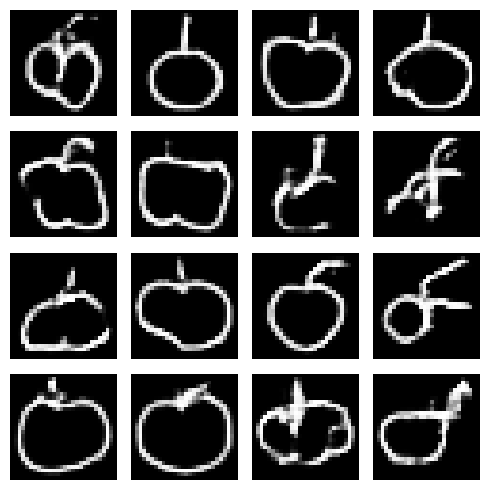

4/4 [==============================] - 0s 12ms/step
Epoch #859
859: [D loss: 0.459580, acc: 0.000000]  [A loss: 1.773543, acc: 0.160916]
1/1 [==============================] - 0s 16ms/step


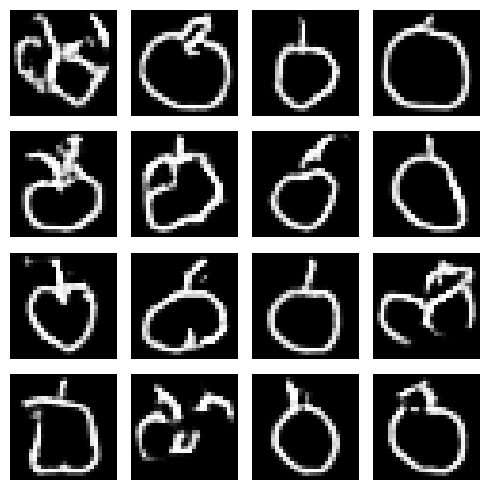

4/4 [==============================] - 0s 12ms/step
Epoch #879
879: [D loss: 0.460087, acc: 0.000000]  [A loss: 1.774746, acc: 0.160152]
1/1 [==============================] - 0s 16ms/step


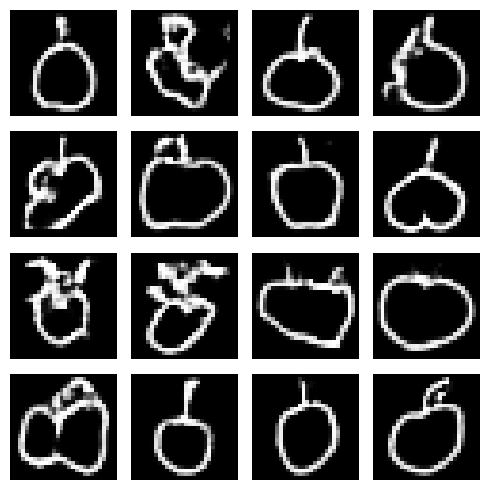

4/4 [==============================] - 0s 12ms/step
Epoch #899
899: [D loss: 0.460301, acc: 0.000000]  [A loss: 1.775509, acc: 0.159622]
1/1 [==============================] - 0s 16ms/step


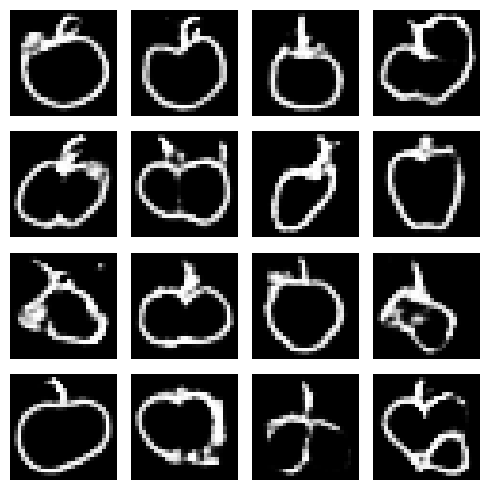

4/4 [==============================] - 0s 12ms/step
Epoch #919
919: [D loss: 0.460300, acc: 0.000000]  [A loss: 1.776701, acc: 0.158800]
1/1 [==============================] - 0s 16ms/step


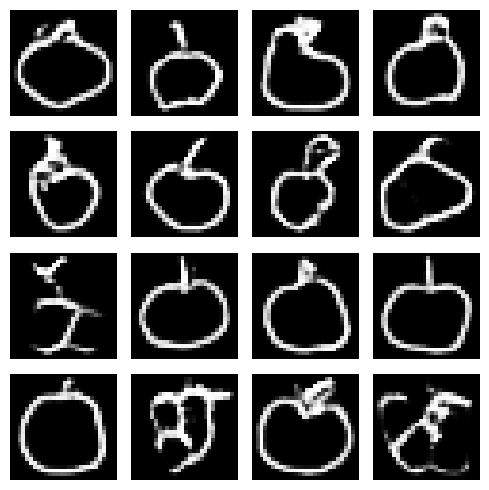

4/4 [==============================] - 0s 13ms/step
Epoch #939
939: [D loss: 0.460300, acc: 0.000000]  [A loss: 1.779001, acc: 0.158030]
1/1 [==============================] - 0s 16ms/step


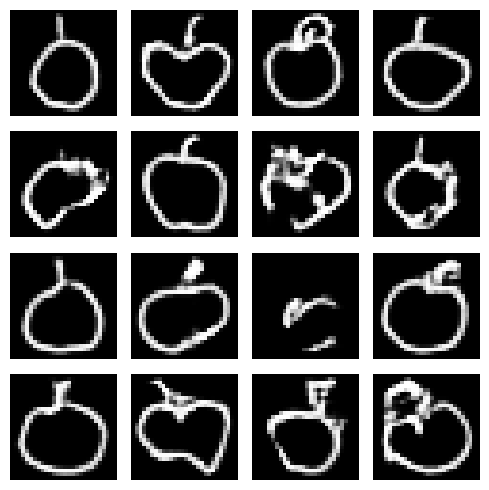

4/4 [==============================] - 0s 12ms/step
Epoch #959
959: [D loss: 0.460374, acc: 0.000000]  [A loss: 1.779371, acc: 0.157399]
1/1 [==============================] - 0s 16ms/step


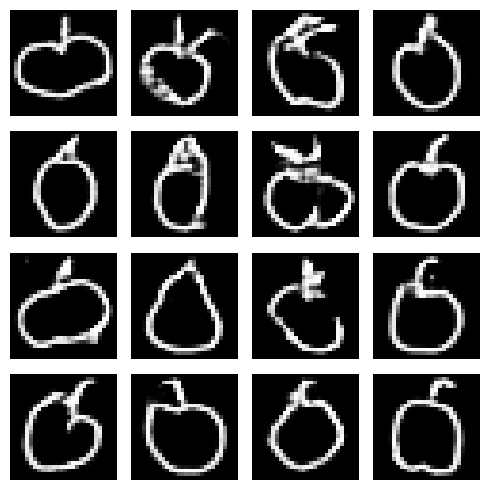

4/4 [==============================] - 0s 12ms/step
Epoch #979
979: [D loss: 0.460392, acc: 0.000000]  [A loss: 1.780506, acc: 0.156593]
1/1 [==============================] - 0s 17ms/step


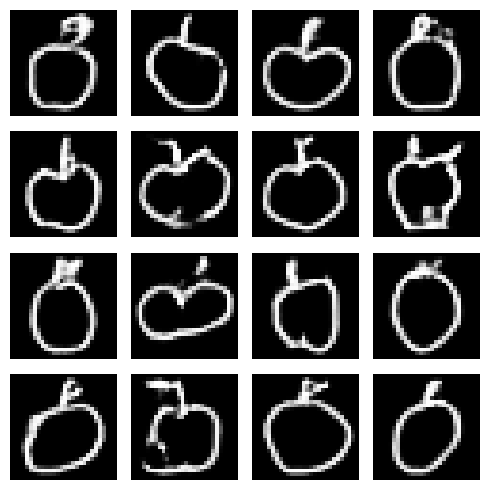

4/4 [==============================] - 0s 12ms/step
Epoch #999
999: [D loss: 0.460515, acc: 0.000000]  [A loss: 1.783349, acc: 0.156117]
1/1 [==============================] - 0s 17ms/step


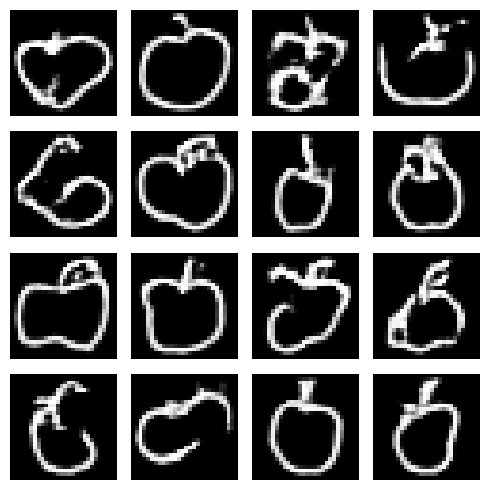

4/4 [==============================] - 0s 12ms/step
Epoch #1019
1019: [D loss: 0.460413, acc: 0.000000]  [A loss: 1.784880, acc: 0.155154]
1/1 [==============================] - 0s 16ms/step


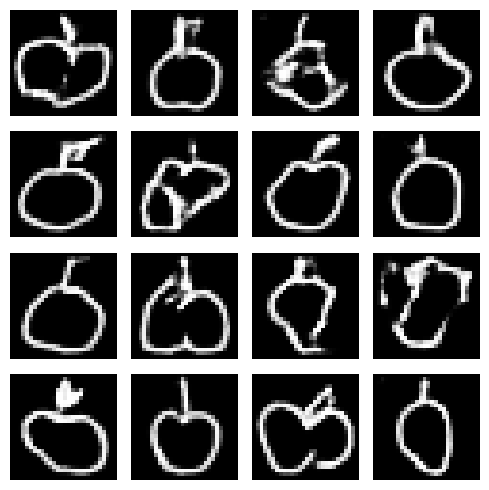

4/4 [==============================] - 0s 12ms/step
Epoch #1039
1039: [D loss: 0.460381, acc: 0.000000]  [A loss: 1.786538, acc: 0.154573]
1/1 [==============================] - 0s 16ms/step


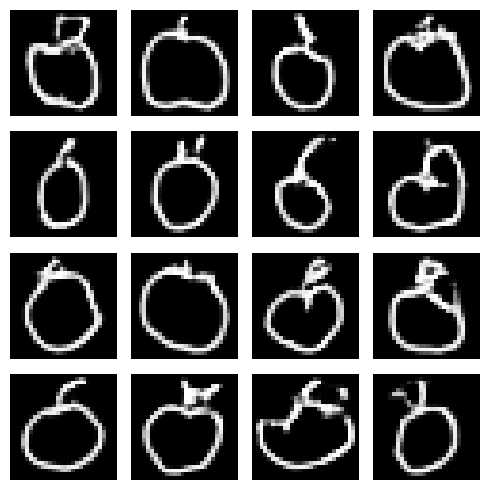

4/4 [==============================] - 0s 14ms/step
Epoch #1059
1059: [D loss: 0.460135, acc: 0.000000]  [A loss: 1.788807, acc: 0.154199]
1/1 [==============================] - 0s 16ms/step


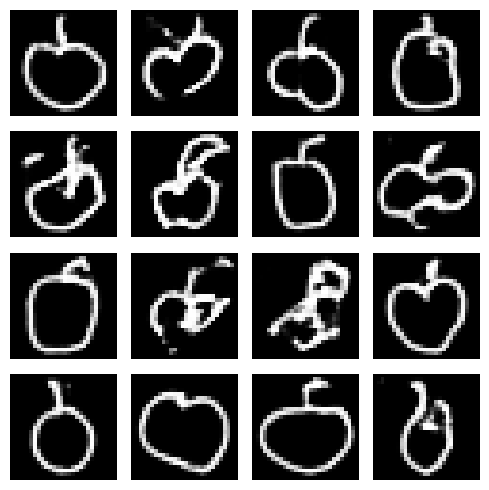

4/4 [==============================] - 0s 12ms/step
Epoch #1079
1079: [D loss: 0.459830, acc: 0.000000]  [A loss: 1.791986, acc: 0.153325]
1/1 [==============================] - 0s 17ms/step


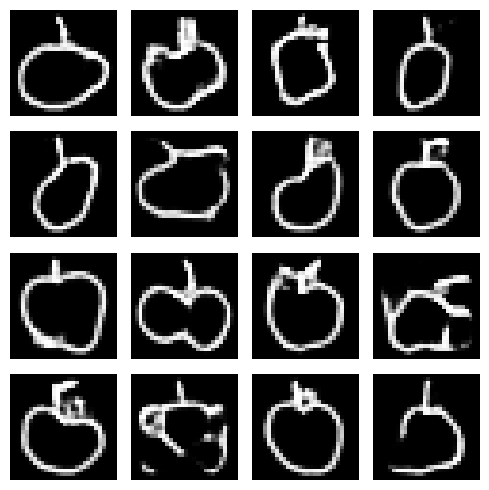

4/4 [==============================] - 0s 12ms/step
Epoch #1099
1099: [D loss: 0.459769, acc: 0.000000]  [A loss: 1.794318, acc: 0.152617]
1/1 [==============================] - 0s 16ms/step


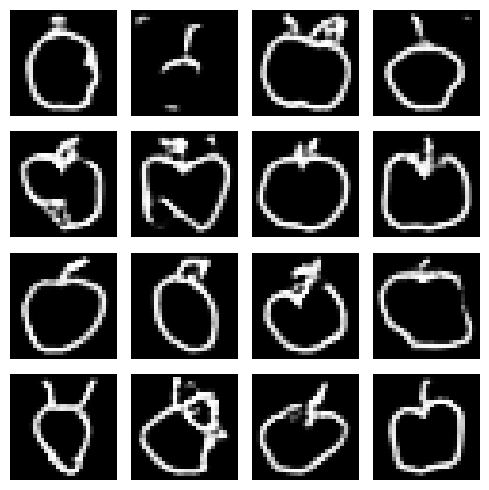

4/4 [==============================] - 0s 13ms/step
Epoch #1119
1119: [D loss: 0.459306, acc: 0.000000]  [A loss: 1.799596, acc: 0.151810]
1/1 [==============================] - 0s 16ms/step


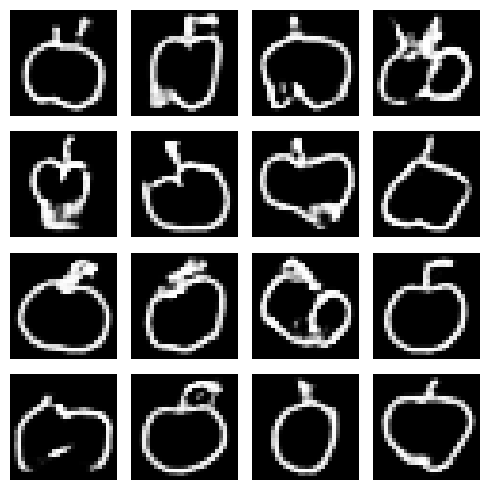

4/4 [==============================] - 0s 12ms/step
Epoch #1139
1139: [D loss: 0.459006, acc: 0.000000]  [A loss: 1.801939, acc: 0.150927]
1/1 [==============================] - 0s 16ms/step


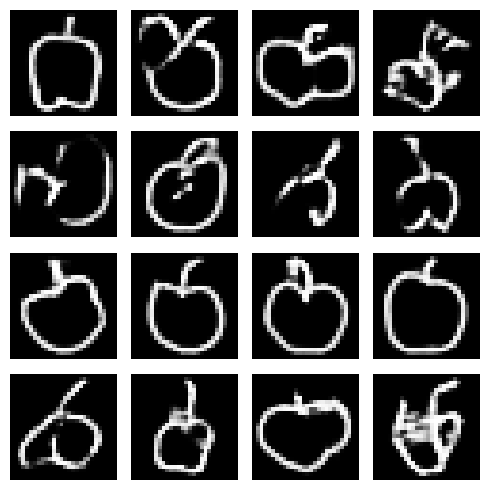

4/4 [==============================] - 0s 12ms/step
Epoch #1159
1159: [D loss: 0.458745, acc: 0.000000]  [A loss: 1.805087, acc: 0.150062]
1/1 [==============================] - 0s 17ms/step


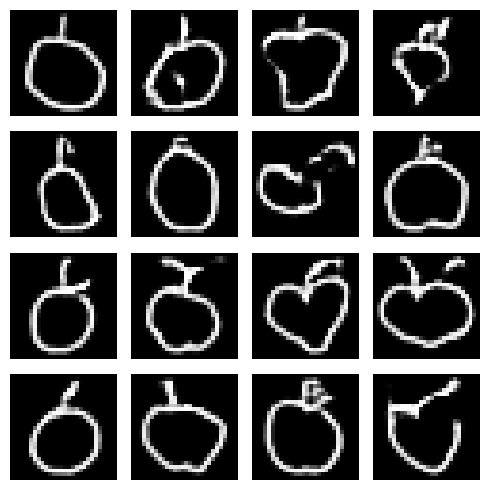

4/4 [==============================] - 0s 12ms/step
Epoch #1179
1179: [D loss: 0.458564, acc: 0.000000]  [A loss: 1.806591, acc: 0.149504]
1/1 [==============================] - 0s 16ms/step


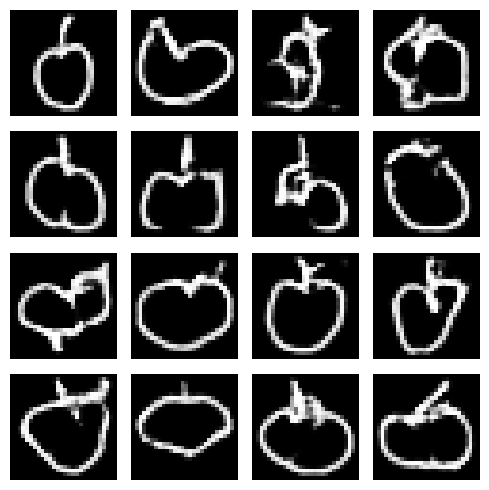

4/4 [==============================] - 0s 15ms/step
Epoch #1199
1199: [D loss: 0.458365, acc: 0.000000]  [A loss: 1.809338, acc: 0.148711]
1/1 [==============================] - 0s 16ms/step


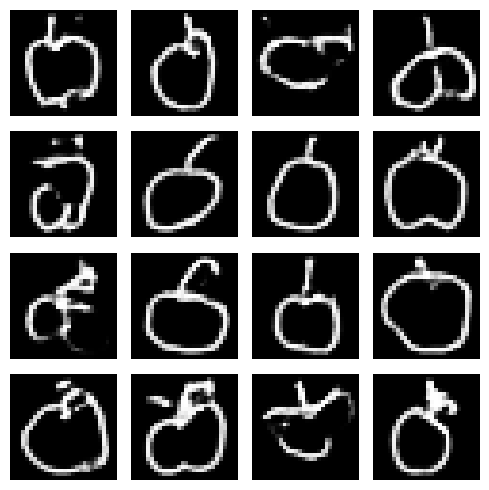

4/4 [==============================] - 0s 15ms/step
Epoch #1219
1219: [D loss: 0.458187, acc: 0.000000]  [A loss: 1.811049, acc: 0.148194]
1/1 [==============================] - 0s 18ms/step


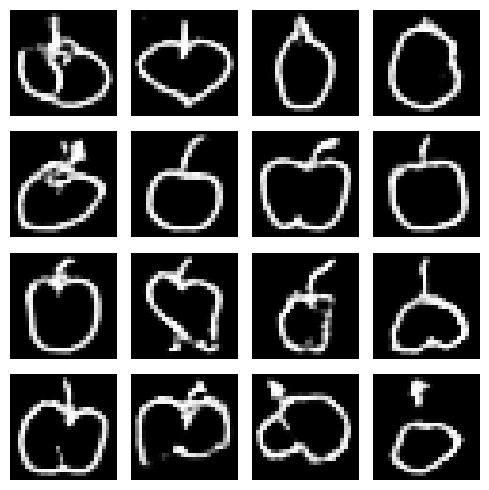

4/4 [==============================] - 0s 12ms/step
Epoch #1239
1239: [D loss: 0.458100, acc: 0.000000]  [A loss: 1.813162, acc: 0.147624]
1/1 [==============================] - 0s 17ms/step


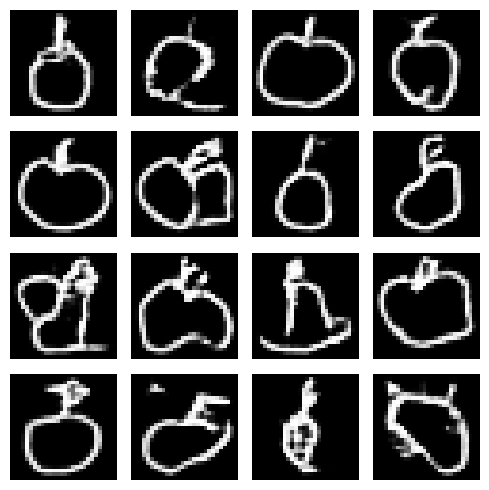

4/4 [==============================] - 0s 12ms/step
Epoch #1259
1259: [D loss: 0.457694, acc: 0.000000]  [A loss: 1.816650, acc: 0.147029]
1/1 [==============================] - 0s 16ms/step


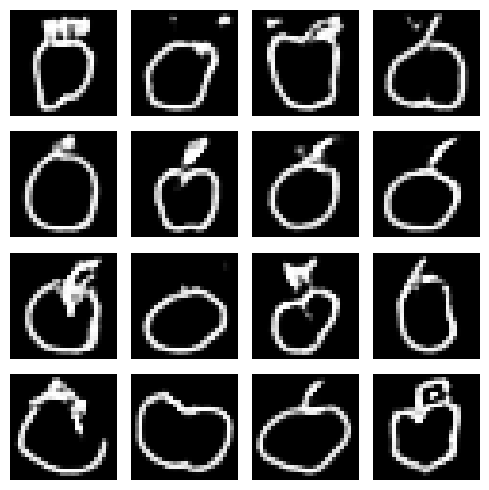

4/4 [==============================] - 0s 12ms/step
Epoch #1279
1279: [D loss: 0.457224, acc: 0.000000]  [A loss: 1.821331, acc: 0.146141]
1/1 [==============================] - 0s 16ms/step


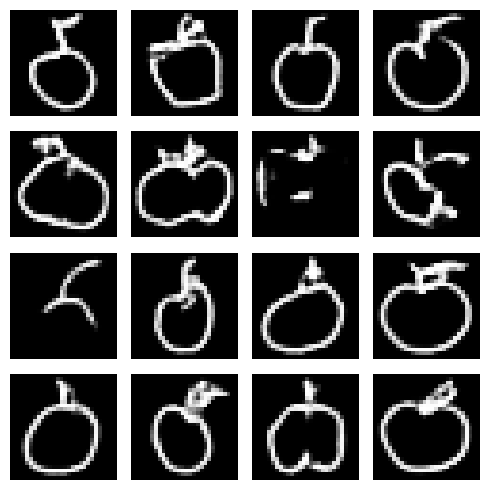

4/4 [==============================] - 0s 13ms/step
Epoch #1299
1299: [D loss: 0.457076, acc: 0.000000]  [A loss: 1.822417, acc: 0.145827]
1/1 [==============================] - 0s 16ms/step


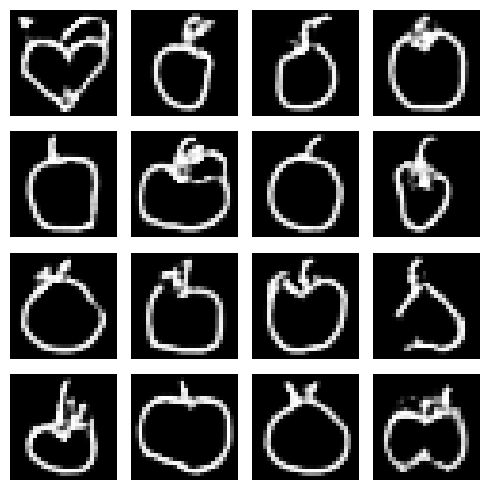

4/4 [==============================] - 0s 12ms/step
Epoch #1319
1319: [D loss: 0.456713, acc: 0.000000]  [A loss: 1.824568, acc: 0.145334]
1/1 [==============================] - 0s 16ms/step


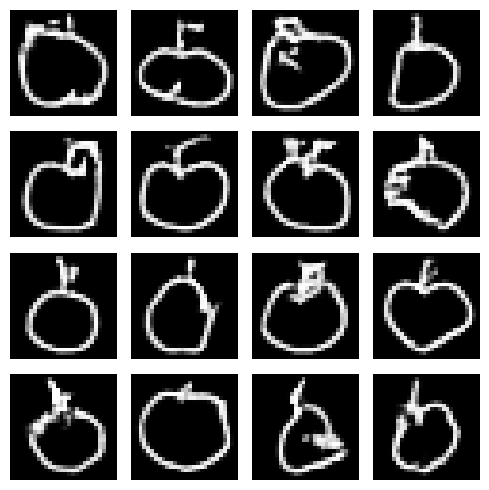

4/4 [==============================] - 0s 12ms/step
Epoch #1339
1339: [D loss: 0.456274, acc: 0.000000]  [A loss: 1.827600, acc: 0.144633]
1/1 [==============================] - 0s 16ms/step


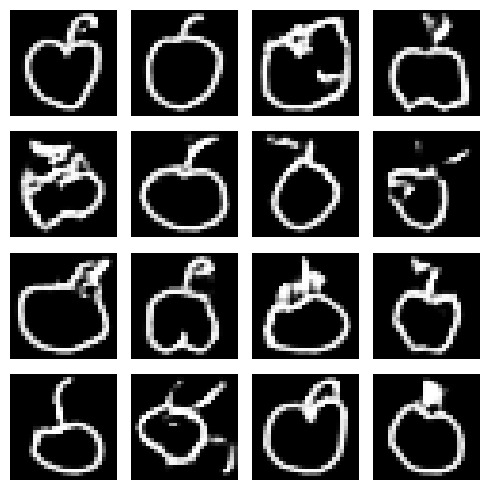

4/4 [==============================] - 0s 14ms/step
Epoch #1359
1359: [D loss: 0.455943, acc: 0.000000]  [A loss: 1.831064, acc: 0.143994]
1/1 [==============================] - 0s 16ms/step


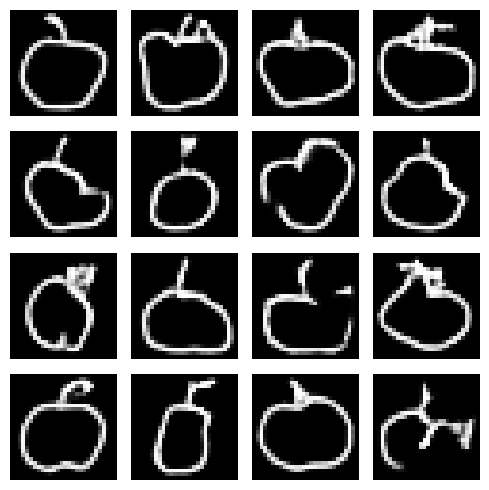

4/4 [==============================] - 0s 12ms/step
Epoch #1379
1379: [D loss: 0.455532, acc: 0.000000]  [A loss: 1.833253, acc: 0.143174]
1/1 [==============================] - 0s 16ms/step


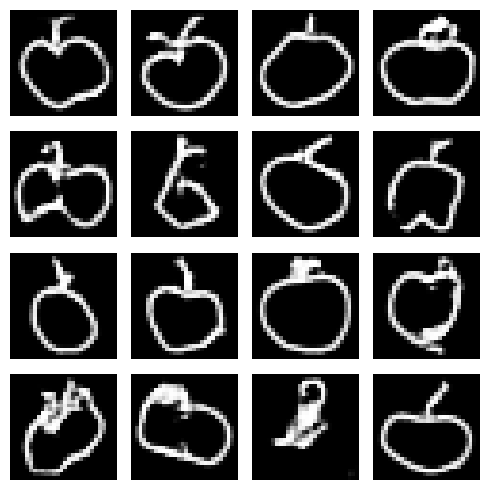

4/4 [==============================] - 0s 13ms/step
Epoch #1399
1399: [D loss: 0.455418, acc: 0.000000]  [A loss: 1.835181, acc: 0.142976]
1/1 [==============================] - 0s 16ms/step


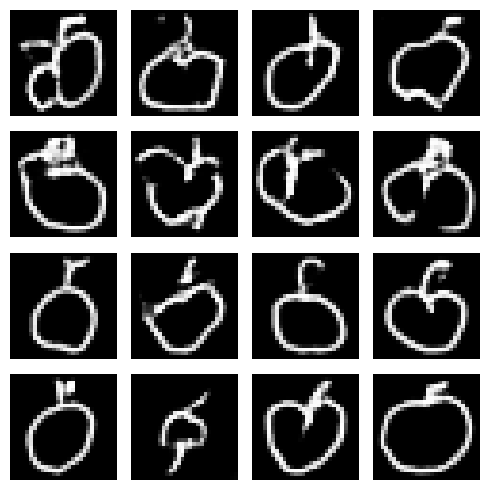

4/4 [==============================] - 0s 12ms/step
Epoch #1419
1419: [D loss: 0.455047, acc: 0.000000]  [A loss: 1.837559, acc: 0.142370]
1/1 [==============================] - 0s 16ms/step


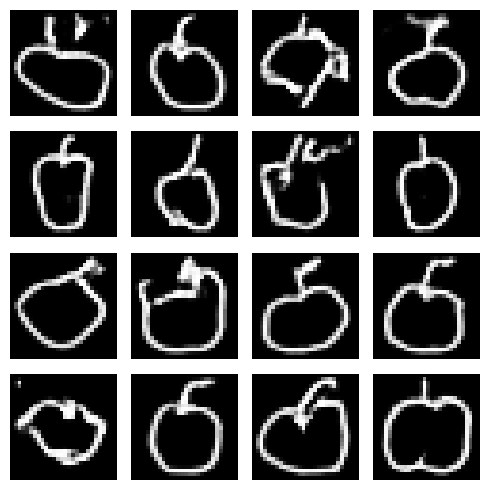

4/4 [==============================] - 0s 13ms/step
Epoch #1439
1439: [D loss: 0.454792, acc: 0.000000]  [A loss: 1.839309, acc: 0.141830]
1/1 [==============================] - 0s 16ms/step


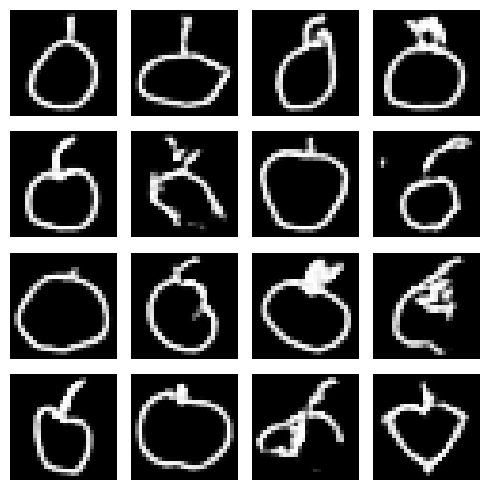

4/4 [==============================] - 0s 13ms/step
Epoch #1459
1459: [D loss: 0.454449, acc: 0.000000]  [A loss: 1.841311, acc: 0.141417]
1/1 [==============================] - 0s 16ms/step


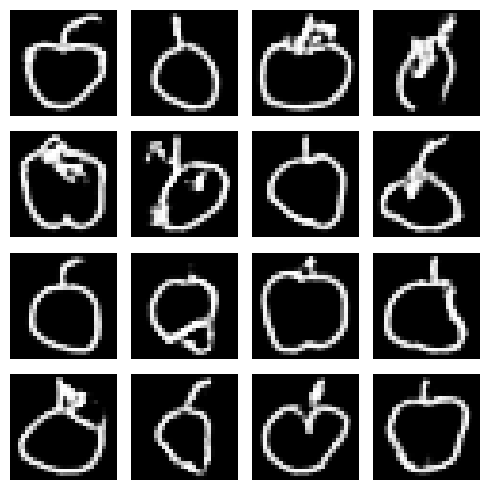

4/4 [==============================] - 0s 12ms/step
Epoch #1479
1479: [D loss: 0.453980, acc: 0.000000]  [A loss: 1.843716, acc: 0.141090]
1/1 [==============================] - 0s 16ms/step


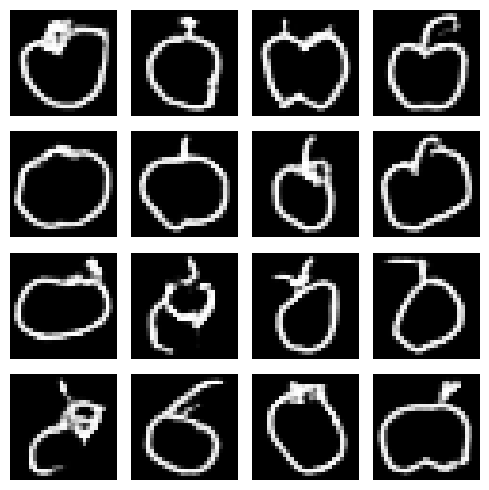

4/4 [==============================] - 0s 12ms/step
Epoch #1499
1499: [D loss: 0.453394, acc: 0.000000]  [A loss: 1.848287, acc: 0.140547]
1/1 [==============================] - 0s 21ms/step


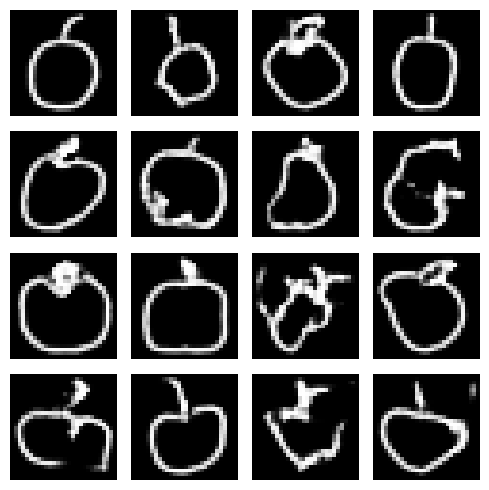

4/4 [==============================] - 0s 12ms/step
Epoch #1519
1519: [D loss: 0.453034, acc: 0.000000]  [A loss: 1.851062, acc: 0.140013]
1/1 [==============================] - 0s 16ms/step


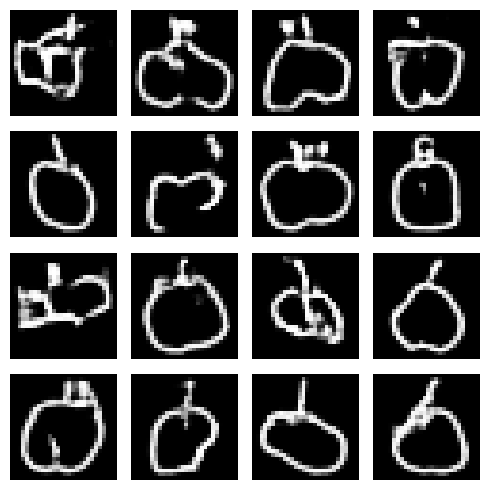

4/4 [==============================] - 0s 12ms/step
Epoch #1539
1539: [D loss: 0.452582, acc: 0.000000]  [A loss: 1.853626, acc: 0.139518]
1/1 [==============================] - 0s 17ms/step


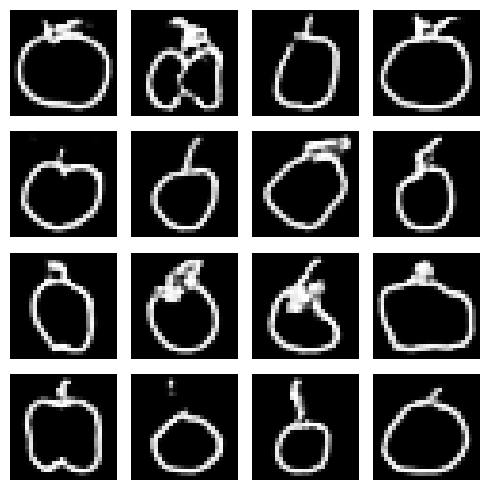

4/4 [==============================] - 0s 12ms/step
Epoch #1559
1559: [D loss: 0.452429, acc: 0.000000]  [A loss: 1.855930, acc: 0.139092]
1/1 [==============================] - 0s 16ms/step


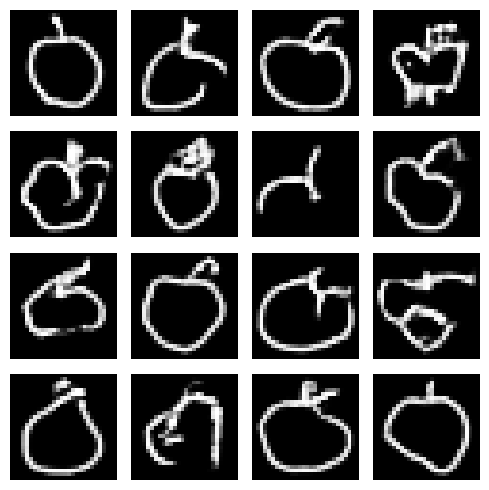

4/4 [==============================] - 0s 12ms/step
Epoch #1579
1579: [D loss: 0.451932, acc: 0.000000]  [A loss: 1.858481, acc: 0.138606]
1/1 [==============================] - 0s 16ms/step


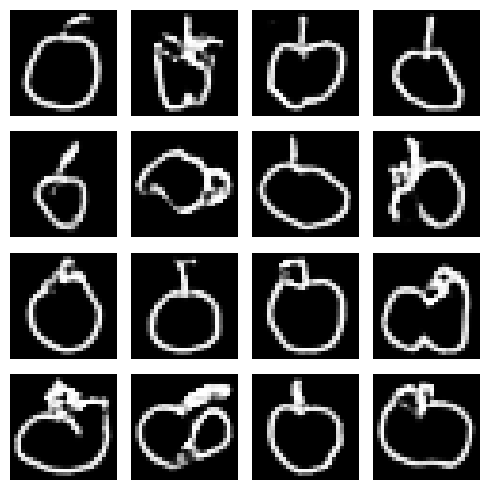

4/4 [==============================] - 0s 12ms/step
Epoch #1599
1599: [D loss: 0.451558, acc: 0.000000]  [A loss: 1.861135, acc: 0.138016]
1/1 [==============================] - 0s 16ms/step


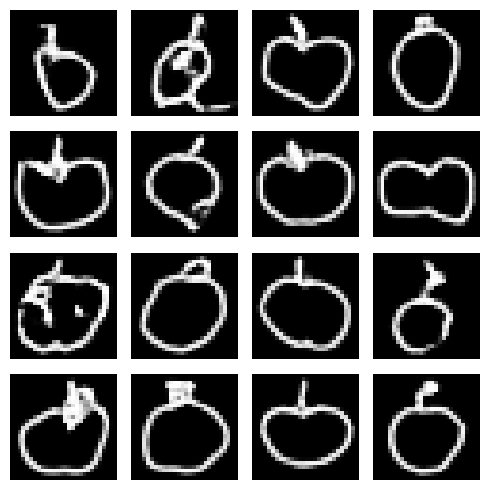

4/4 [==============================] - 0s 13ms/step
Epoch #1619
1619: [D loss: 0.451173, acc: 0.000000]  [A loss: 1.863976, acc: 0.137513]
1/1 [==============================] - 0s 17ms/step


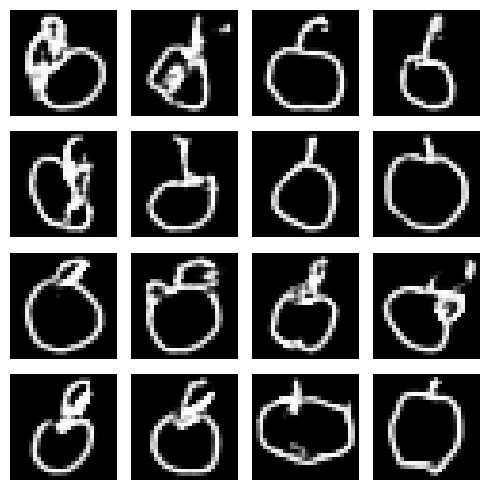

4/4 [==============================] - 0s 13ms/step
Epoch #1639
1639: [D loss: 0.450855, acc: 0.000000]  [A loss: 1.866563, acc: 0.137150]
1/1 [==============================] - 0s 16ms/step


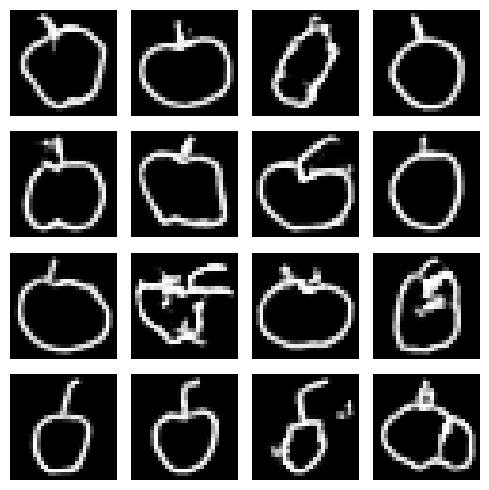

4/4 [==============================] - 0s 14ms/step
Epoch #1659
1659: [D loss: 0.450245, acc: 0.000000]  [A loss: 1.870287, acc: 0.136504]
1/1 [==============================] - 0s 16ms/step


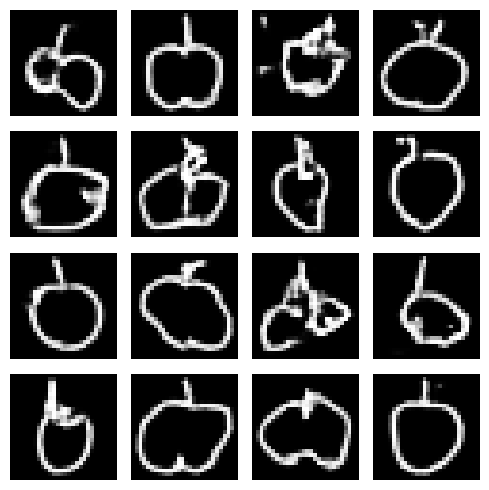

4/4 [==============================] - 0s 14ms/step
Epoch #1679
1679: [D loss: 0.449800, acc: 0.000000]  [A loss: 1.872959, acc: 0.136098]
1/1 [==============================] - 0s 17ms/step


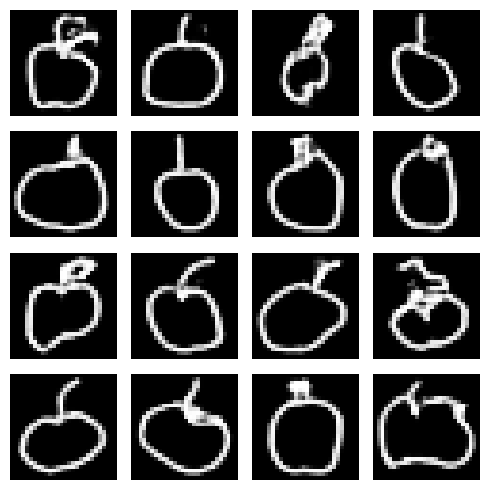

4/4 [==============================] - 0s 13ms/step
Epoch #1699
1699: [D loss: 0.449414, acc: 0.000000]  [A loss: 1.876189, acc: 0.135732]
1/1 [==============================] - 0s 16ms/step


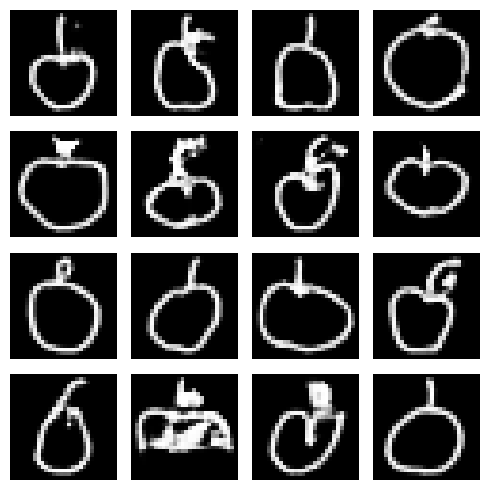

4/4 [==============================] - 0s 16ms/step
Epoch #1719
1719: [D loss: 0.449059, acc: 0.000000]  [A loss: 1.878698, acc: 0.135371]
1/1 [==============================] - 0s 17ms/step


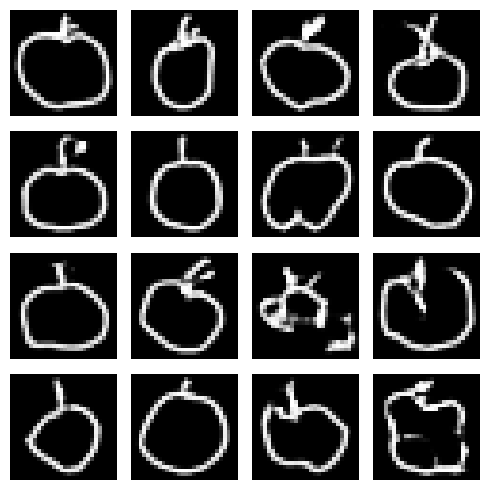

4/4 [==============================] - 0s 13ms/step
Epoch #1739
1739: [D loss: 0.448842, acc: 0.000000]  [A loss: 1.881122, acc: 0.134964]
1/1 [==============================] - 0s 15ms/step


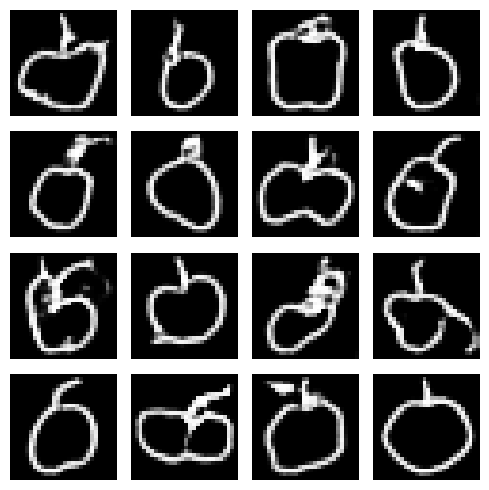

4/4 [==============================] - 0s 12ms/step
Epoch #1759
1759: [D loss: 0.448436, acc: 0.000000]  [A loss: 1.884361, acc: 0.134376]
1/1 [==============================] - 0s 16ms/step


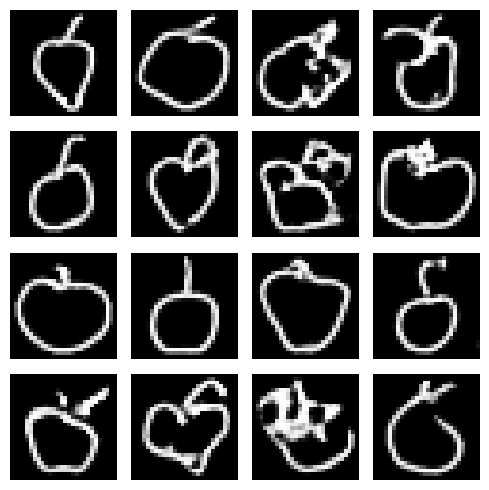

4/4 [==============================] - 0s 12ms/step
Epoch #1779
1779: [D loss: 0.448073, acc: 0.000000]  [A loss: 1.886647, acc: 0.133906]
1/1 [==============================] - 0s 18ms/step


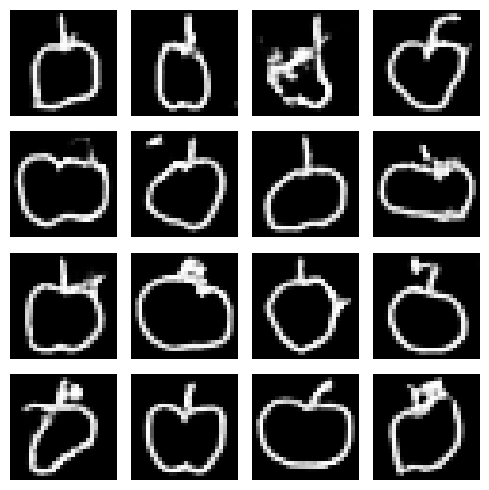

4/4 [==============================] - 0s 13ms/step
Epoch #1799
1799: [D loss: 0.447748, acc: 0.000000]  [A loss: 1.888392, acc: 0.133473]
1/1 [==============================] - 0s 16ms/step


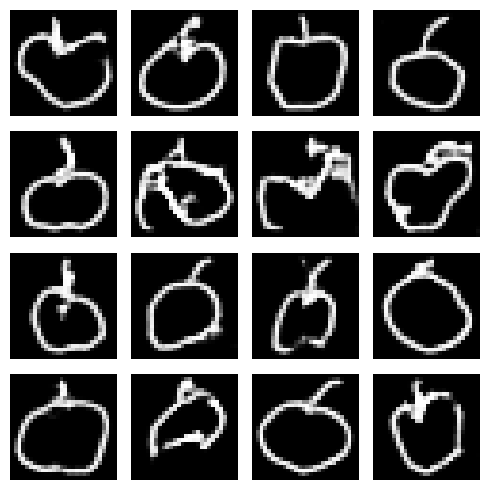

4/4 [==============================] - 0s 14ms/step
Epoch #1819
1819: [D loss: 0.447180, acc: 0.000000]  [A loss: 1.892020, acc: 0.132946]
1/1 [==============================] - 0s 17ms/step


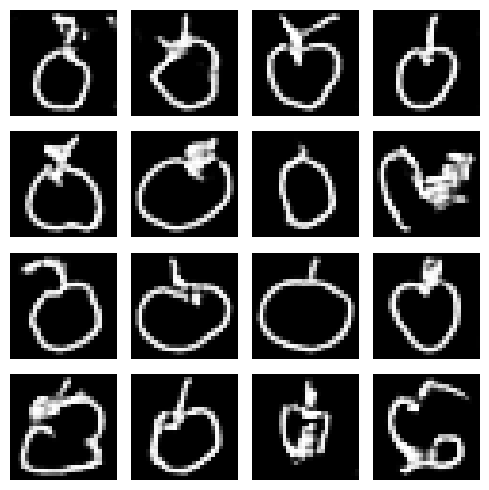

4/4 [==============================] - 0s 13ms/step
Epoch #1839
1839: [D loss: 0.446918, acc: 0.000000]  [A loss: 1.893751, acc: 0.132634]
1/1 [==============================] - 0s 16ms/step


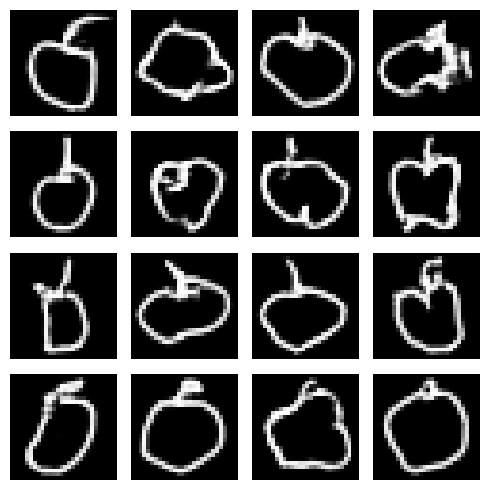

4/4 [==============================] - 0s 12ms/step
Epoch #1859
1859: [D loss: 0.446495, acc: 0.000000]  [A loss: 1.896817, acc: 0.132018]
1/1 [==============================] - 0s 17ms/step


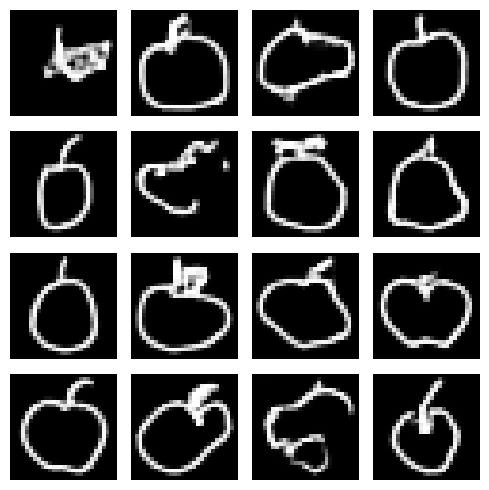

4/4 [==============================] - 0s 12ms/step
Epoch #1879
1879: [D loss: 0.446182, acc: 0.000000]  [A loss: 1.899815, acc: 0.131723]
1/1 [==============================] - 0s 16ms/step


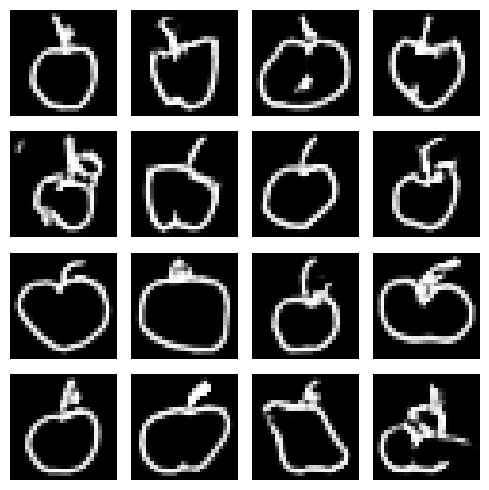

4/4 [==============================] - 0s 12ms/step
Epoch #1899
1899: [D loss: 0.445773, acc: 0.000000]  [A loss: 1.901947, acc: 0.131381]
1/1 [==============================] - 0s 15ms/step


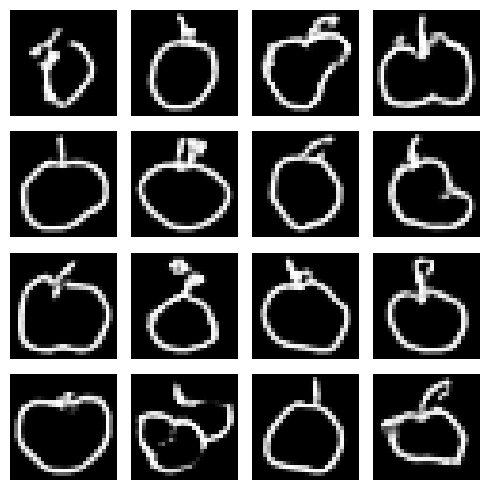

4/4 [==============================] - 0s 12ms/step
Epoch #1919
1919: [D loss: 0.445422, acc: 0.000000]  [A loss: 1.904914, acc: 0.130960]
1/1 [==============================] - 0s 17ms/step


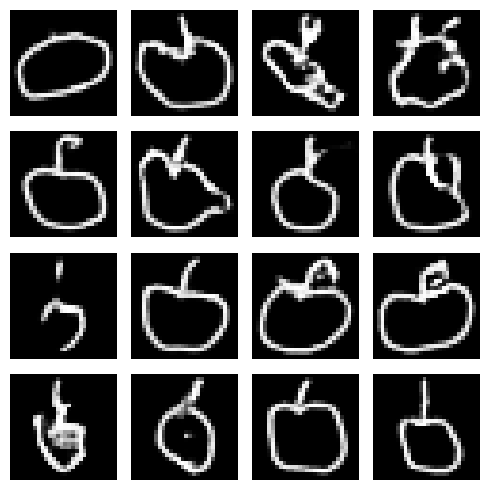

4/4 [==============================] - 0s 12ms/step
Epoch #1939
1939: [D loss: 0.445089, acc: 0.000000]  [A loss: 1.907801, acc: 0.130536]
1/1 [==============================] - 0s 15ms/step


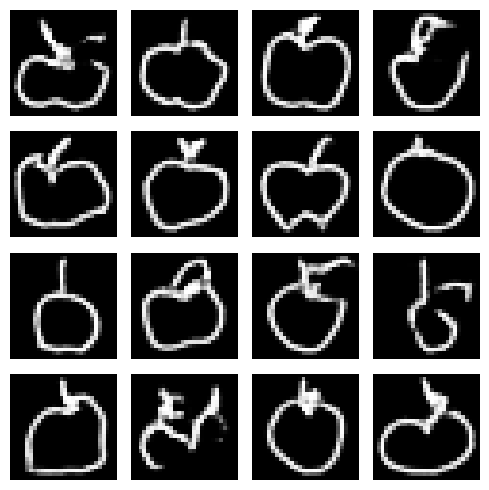

4/4 [==============================] - 0s 14ms/step
Epoch #1959
1959: [D loss: 0.444802, acc: 0.000000]  [A loss: 1.909918, acc: 0.130224]
1/1 [==============================] - 0s 16ms/step


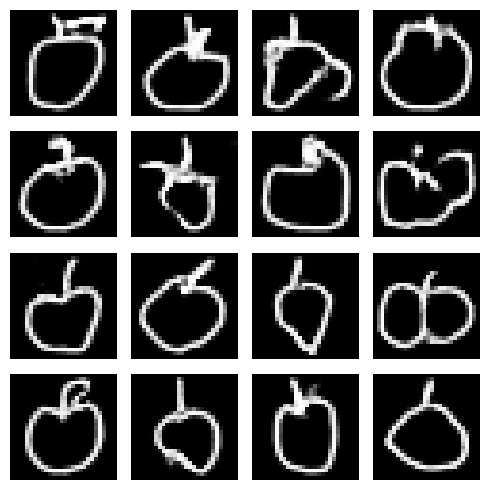

4/4 [==============================] - 0s 13ms/step
Epoch #1979
1979: [D loss: 0.444425, acc: 0.000000]  [A loss: 1.912946, acc: 0.129800]
1/1 [==============================] - 0s 17ms/step


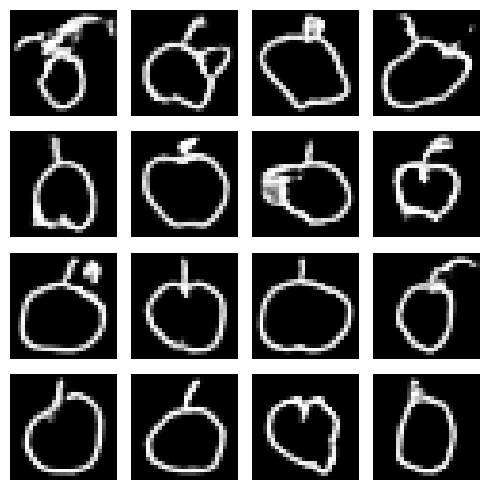

4/4 [==============================] - 0s 12ms/step
Epoch #1999
1999: [D loss: 0.444055, acc: 0.000000]  [A loss: 1.915888, acc: 0.129358]
1/1 [==============================] - 0s 16ms/step


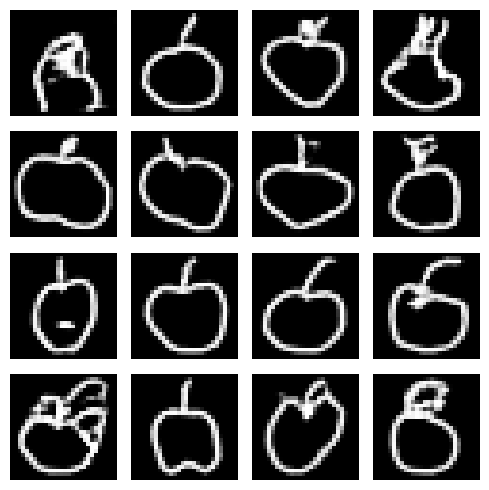

In [32]:
a_metrics_complete, d_metrics_complete = train()

Text(0, 0.5, 'Loss')

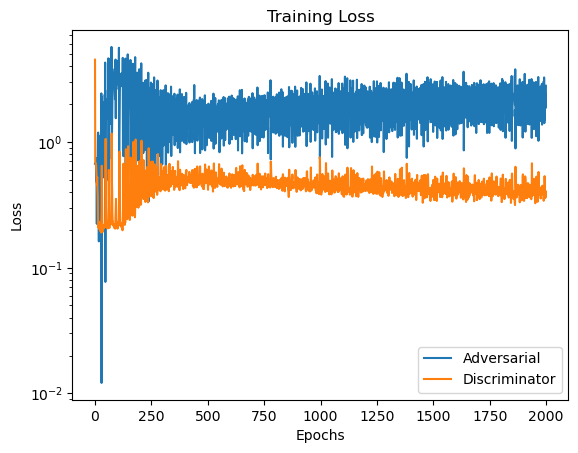

In [33]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

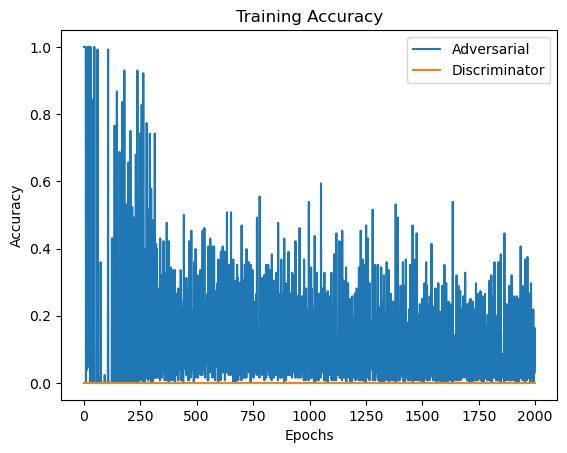

In [34]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")